### Deadline 2022-06-27 23:59:59

# Первая нейросетка

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('data.csv', index_col=0)

Как и в любой задаче машинного обучения для начала надо визуализировать данные. 
Не зря же нашу нейронную сеть мы так долго учим?


<AxesSubplot:xlabel='x1', ylabel='x2'>

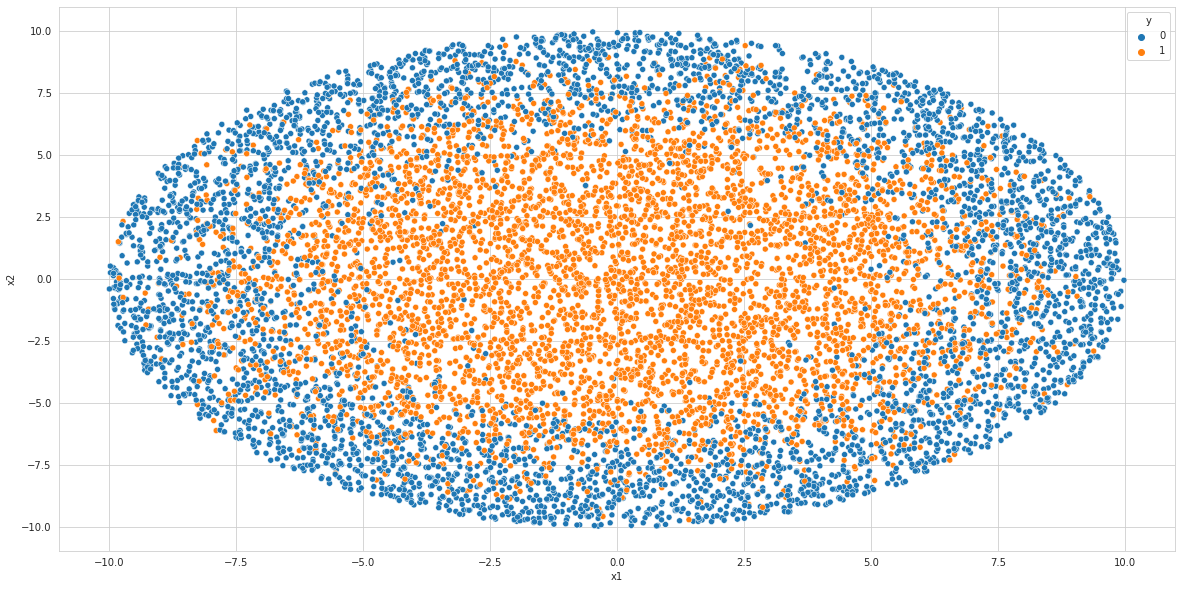

In [11]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# разобьем выборку на трэйн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['y'], test_size=0.33)

Точность нашей модели 0.5896969696969697


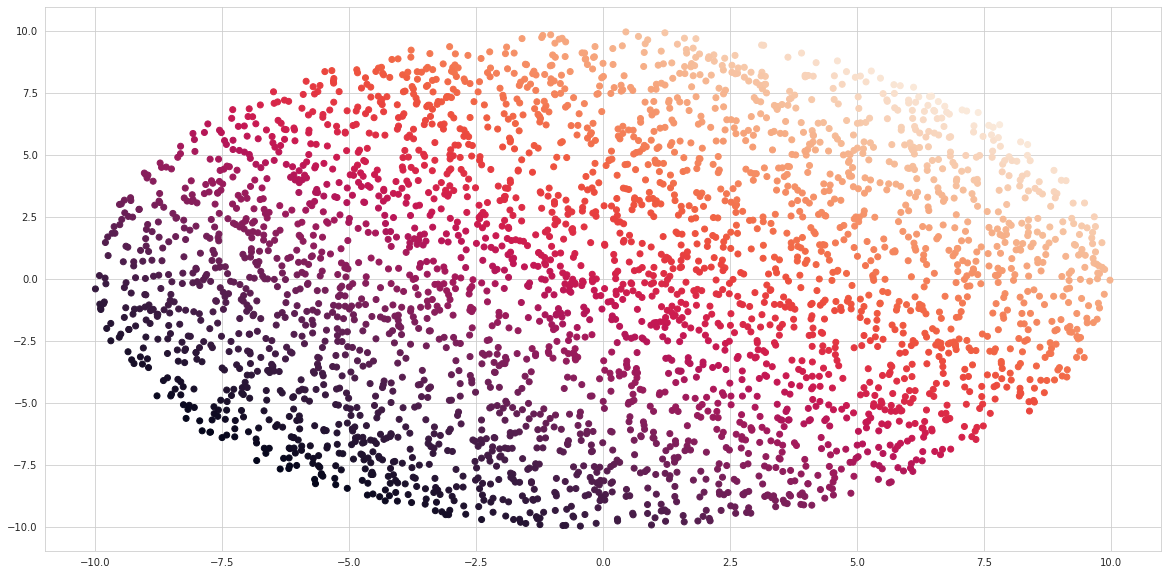

In [13]:
from sklearn.linear_model import LogisticRegression

#########################################
# Ваш код для Логистической регрессии

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

predict_logit = lr_model.predict(X_test)
predict_log_proba = lr_model.predict_log_proba(X_test)[:, 1]

#########################################


print(f'Точность нашей модели {accuracy_score(predict_logit, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba)
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

In [14]:
df.head(5)

,x1,x2,y
0,-4.626272,-6.658988,0
1,-7.789640,0.262519,0
2,-8.739678,1.537758,0
3,-2.546441,-7.705224,0
4,-2.751506,-7.940187,0


In [15]:
df.describe()

,x1,x2,y
count,10000.000000,10000.000000,10000.000000
mean,-0.029488,-0.098799,0.509700
std,4.981907,5.022414,0.499931
min,-9.988732,-9.972095,0.000000
25%,-4.062951,-4.170403,0.000000
50%,-0.063085,-0.097836,1.000000
75%,4.016095,3.880448,1.000000
max,9.985560,9.982304,1.000000


Точность нашей модели 0.5957575757575757


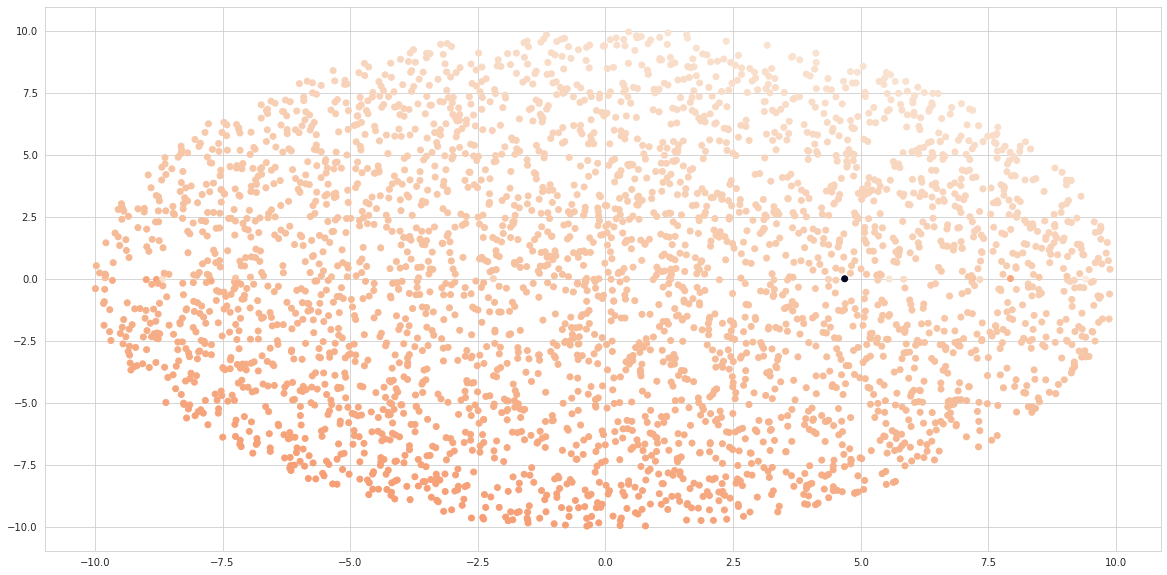

In [16]:
# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()

#########################################
# ваш код для фичей и новой модели

df_new['new_feature_1'] = df_new['x1'] / df_new['x2']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']],
                                                                    df_new['y'], test_size=0.33)
lr_model_new = LogisticRegression()
lr_model_new.fit(X_train_new, y_train_new)
predict_logit = lr_model_new.predict(X_test_new)
predict_log_proba = lr_model_new.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Для того, чтоб совсем не списывать со счетов линейную регрессию, попробуем оптимизировать гиперпараметры с помощью библиотеки optuna

In [17]:
!pip install optuna
import optuna

# находим оптимальные параметры с помощью optuna

def lr_model_new_tr(trial: optuna.Trial) -> float:
    mi = trial.suggest_int(name='max_iter', low=100, high=100000)
    tl = trial.suggest_float(name='tol', low=1e-4, high=1)
    c = trial.suggest_float(name='C', low=1e-10, high=1000)
    cw = trial.suggest_categorical(name='class_weight', choices=['balanced', None])

    lr_model_mule = LogisticRegression(penalty='l2', max_iter=mi, tol=tl, C=c, class_weight=cw, solver='lbfgs').fit(
        X_train_new, y_train_new)
    pr = lr_model_mule.predict(X_test_new)
    score = accuracy_score(pr, y_test_new)

    return score


lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(lr_model_new_tr, n_trials=1000)

Улучшили результат модели!

Точность нашей модели 0.5969696969696969


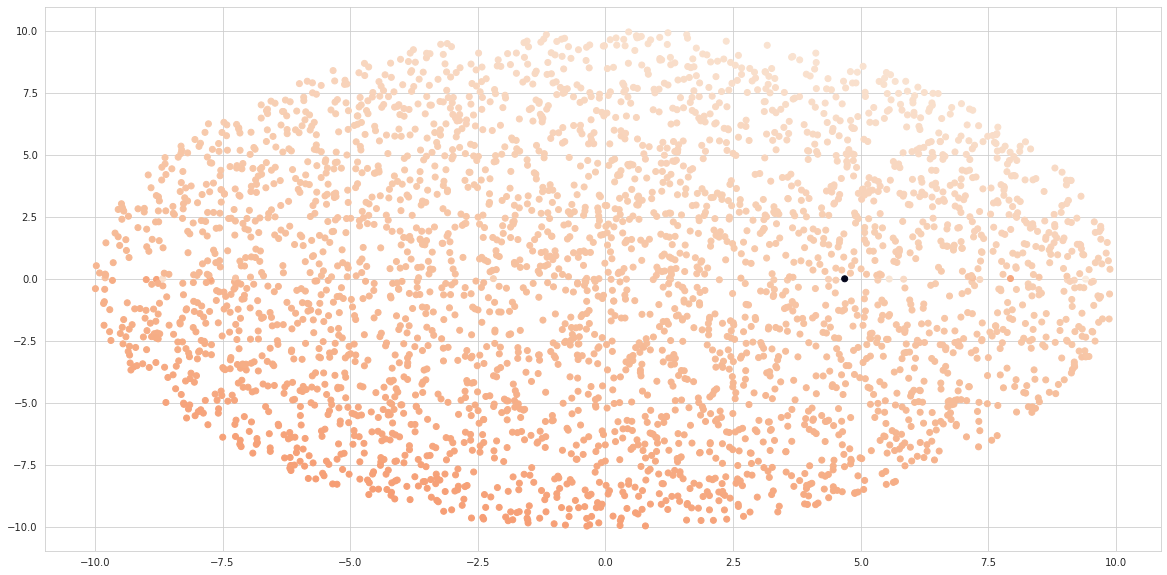

In [19]:
# подобранные optuna параметры:
# {'max_iter': 37228, 'tol': 0.18600712367470443, 'C': 0.006745990048031558, 'class_weight': None}.

lr_model_neo = LogisticRegression(max_iter=37228, tol=0.18600712367470443, C=0.006745990048031558, class_weight=None)
lr_model_neo.fit(X_train_new, y_train_new)
predict_logit = lr_model_neo.predict(X_test_new)
predict_log_proba = lr_model_neo.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафиксировать, чтобы эта особенность не испортила обучение?

In [20]:
from sklearn.tree import DecisionTreeClassifier

# с помощью optuna оптимизируем глубину
def tree_model_tr(trial: optuna.Trial) -> float:
    sp = trial.suggest_categorical(name='splitter', choices=['best', 'random'])
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)

    tree_model_mule = DecisionTreeClassifier(splitter=sp, max_depth=md, min_samples_split=ms, criterion='gini').fit(
        X_train, y_train)
    pr = tree_model_mule.predict(X_test)
    return accuracy_score(pr, y_test)


tree_study = optuna.create_study(direction='maximize')
tree_study.optimize(tree_model_tr, n_trials=1000)


In [ ]:
#########################################
# Ваш код

# optuna подсказала: 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 10
tree_model = DecisionTreeClassifier(splitter='random', max_depth=11, min_samples_split=10)
tree_model.fit(X_train, y_train)

predict_tree = tree_model.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test)}')

predict_tree_proba = tree_model.predict_proba(X_test)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_tree_proba)
plt.show()

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

In [23]:
from sklearn.ensemble import RandomForestClassifier

# очень нравится optuna применю её и здесь
def forest_model_tr(trial: optuna.Trial) -> float:
    n = trial.suggest_int(name='n_estimators', low=10, high=1000)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    bs = trial.suggest_categorical(name='bootstrap', choices=[True, False])

    forest_model_mule = RandomForestClassifier(n_estimators=n, criterion='gini', min_samples_split=ms, max_depth=md,
                                               bootstrap=bs).fit(X_train, y_train)
    pr = forest_model_mule.predict(X_test)
    return accuracy_score(pr, y_test)


forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(forest_model_tr, n_trials=100)

Точность нашей модели 0.823030303030303


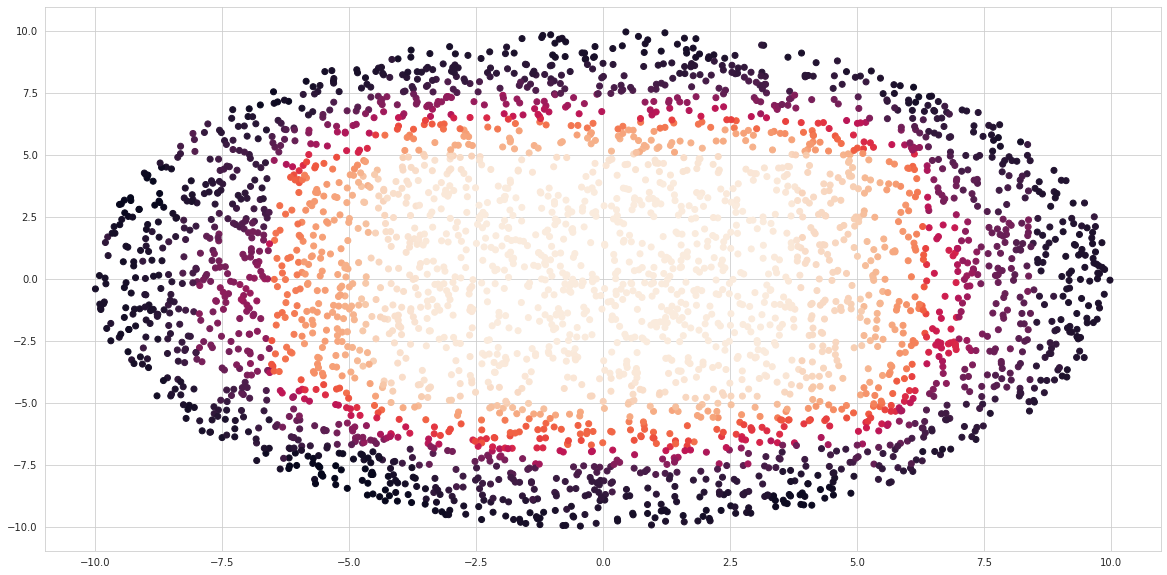

In [27]:
#########################################
# Ваш код

# optuna подсказала: 'n_estimators': 706, 'min_samples_split': 10, 'max_depth': 7, 'bootstrap': True
n = 706
ms = 10
md = 7
bs = True
forest_model = RandomForestClassifier(n_estimators=n, criterion='gini', min_samples_split=ms, max_depth=md,
                                      bootstrap=bs)
forest_model.fit(X_train, y_train)
predict_forest = forest_model.predict(X_test)
print(f'Точность нашей модели {accuracy_score(predict_forest, y_test)}')

predict_forest_proba = forest_model.predict_proba(X_test)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest_proba)
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом. Смотрим на предыдущую тетрадку и копипастим все, что мы там видим! (можно для убыстрения процесса добавить callback с ранней остановкой)

In [28]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 6.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 2.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━

In [8]:
# Подгружаем tensorflow 
import tensorflow as tf

keras = tf.keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.models import Sequential  # Последовательность слоёв
import tensorflow.keras.layers as L  # Разные слои
import tensorflow.keras.optimizers as opt  # Оптимизаторы

2.9.1
2.9.0


На этом наше приключение сегодня закончилось. Вопросы максимально желательны :)

104/104 [==============================] - 0s 843us/step
Точность нашей модели 0.5224242424242425


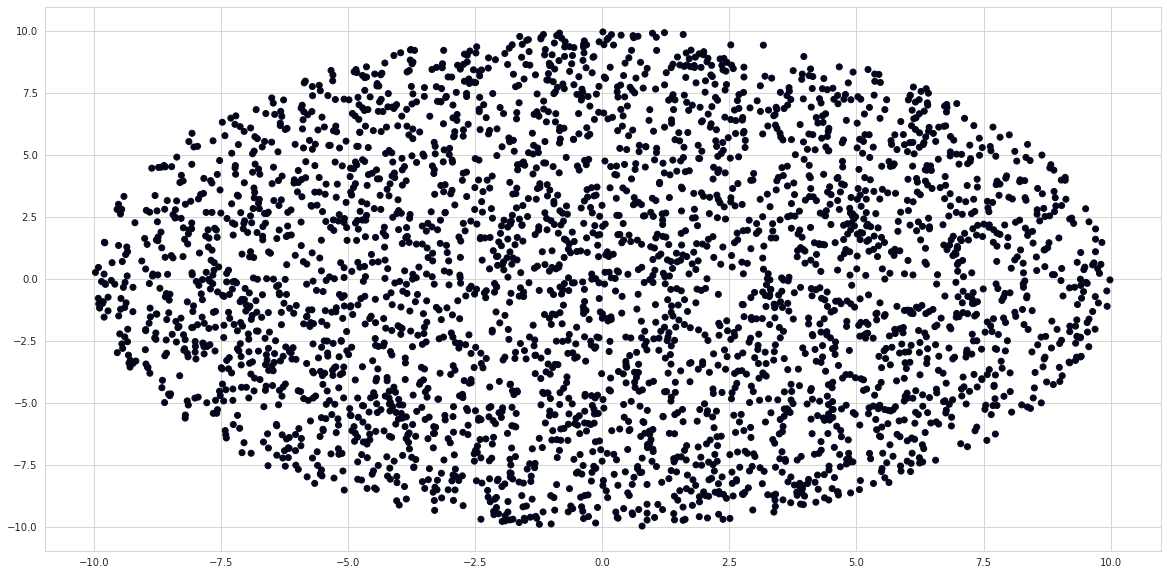

In [48]:
#########################################
# Ваш код

def get_neural_model():
    neural_model = Sequential()
    neural_model.add(L.Dense(5, input_dim=X_test.shape[1], kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(5, kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(2, activation='softmax', kernel_initializer='random_normal'))
    optimizer = opt.Adam(learning_rate=1e-3)

    neural_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return neural_model

my_first_neural_model = get_neural_model()
my_first_neural_model.fit(X_train, y_train)

predict_neural =  my_first_neural_model.predict(X_test)
predict_classes =  tf.argmax(predict_neural, axis=1).numpy()

print(f'Точность нашей модели {accuracy_score(predict_classes, y_test)}')
#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_classes)
plt.show()
